## Import Libraries for Data Handling, Visualization, and CNN

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D


## Load dataset

In [3]:
TRAIN_DIR="/content/train/"
TEST_DIR="/content/test/"


## PreProcessing

### Loading Image Paths and Corresponding Labels

In [4]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if not os.path.isdir(label_path):
            continue  # skip files like .DS_Store

        for filename in os.listdir(label_path):
            image_path = os.path.join(label_path, filename)
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

### Create and Shuffle Training DataFrame

In [5]:
# Convert into DataFrame
train = pd.DataFrame()  # Initialize an empty DataFrame
train['image'], train['label'] = load_dataset(TRAIN_DIR)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()


,image,label
0,/content/train/disgust/aug_7464_2.jpg,disgust
1,/content/train/sad/Training_1956927.jpg,sad
2,/content/train/sad/Training_67985555.jpg,sad
3,/content/train/neutral/Training_48205255.jpg,neutral
4,/content/train/happy/Training_21614218.jpg,happy


In [6]:

# Convert into DataFrame
test = pd.DataFrame()  # Initialize an empty DataFrame
test['image'], test['label'] = load_dataset(TEST_DIR)

test.head()

,image,label
0,/content/test/happy/PublicTest_55888619.jpg,happy
1,/content/test/happy/PublicTest_74227592.jpg,happy
2,/content/test/happy/PrivateTest_25427646.jpg,happy
3,/content/test/happy/PublicTest_29065605.jpg,happy
4,/content/test/happy/PrivateTest_34104108.jpg,happy


Text(0.5, 1.0, 'Distribution of training data')

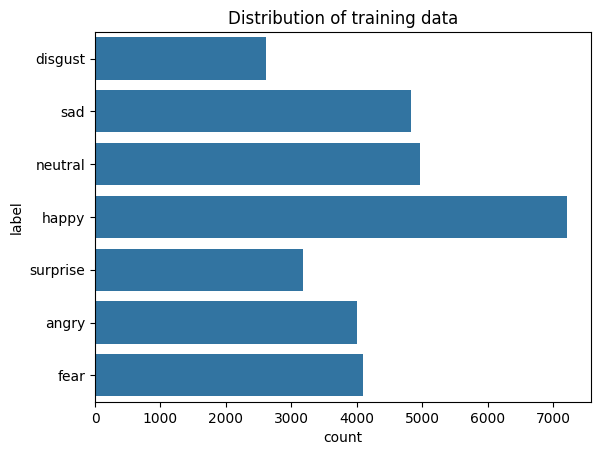

In [7]:
sns.countplot(train['label'])
plt.title("Distribution of training data")

### Image Augmentation for Class Balancing

In [ ]:
from torchvision import transforms
from PIL import Image
import os

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0))
])

augmented_data = []
output_dir = "/content/train/disgust"

os.makedirs(output_dir, exist_ok=True)

for idx, row in disgust_df.iterrows():
    img_path = row['image']
    label = row['label']

    img = Image.open(img_path).convert("RGB")

    for i in range(5):  # Create 5 augmentations per image
        aug_img = augment(img)
        aug_path = os.path.join(output_dir, f"aug_{idx}_{i}.jpg")
        aug_img.save(aug_path)
        augmented_data.append({'image': aug_path, 'label': label})

In [11]:
augmented_df = pd.DataFrame(augmented_data)
train = pd.concat([train, augmented_df], ignore_index=True)

In [9]:
# Assuming 'train' contains image paths and labels
disgust_df = train[train['label'] == 'disgust']

## Exploratory Data Analysis (EDA) on Training Set

Text(0.5, 1.0, 'Distribution of training data')

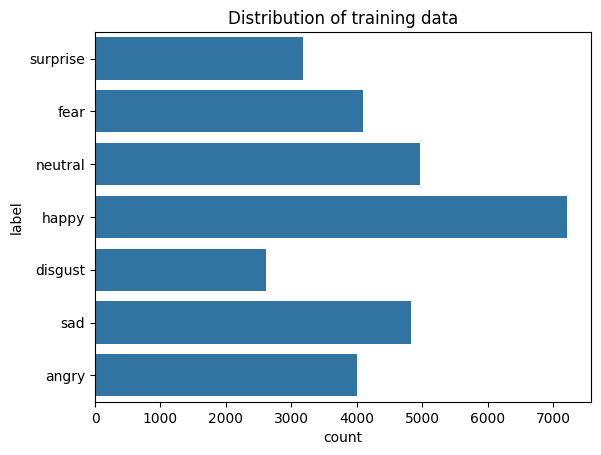

In [12]:
sns.countplot(train['label'])
plt.title("Distribution of training data")

### Display Example Image from Training Set & Extract and Preprocess Image Features

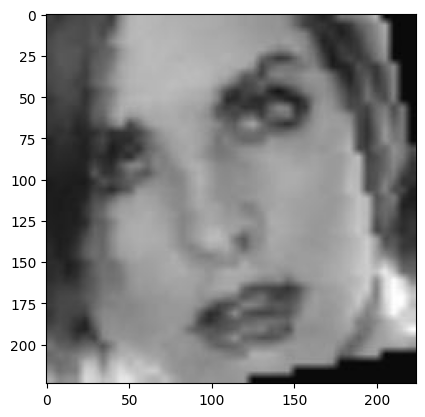

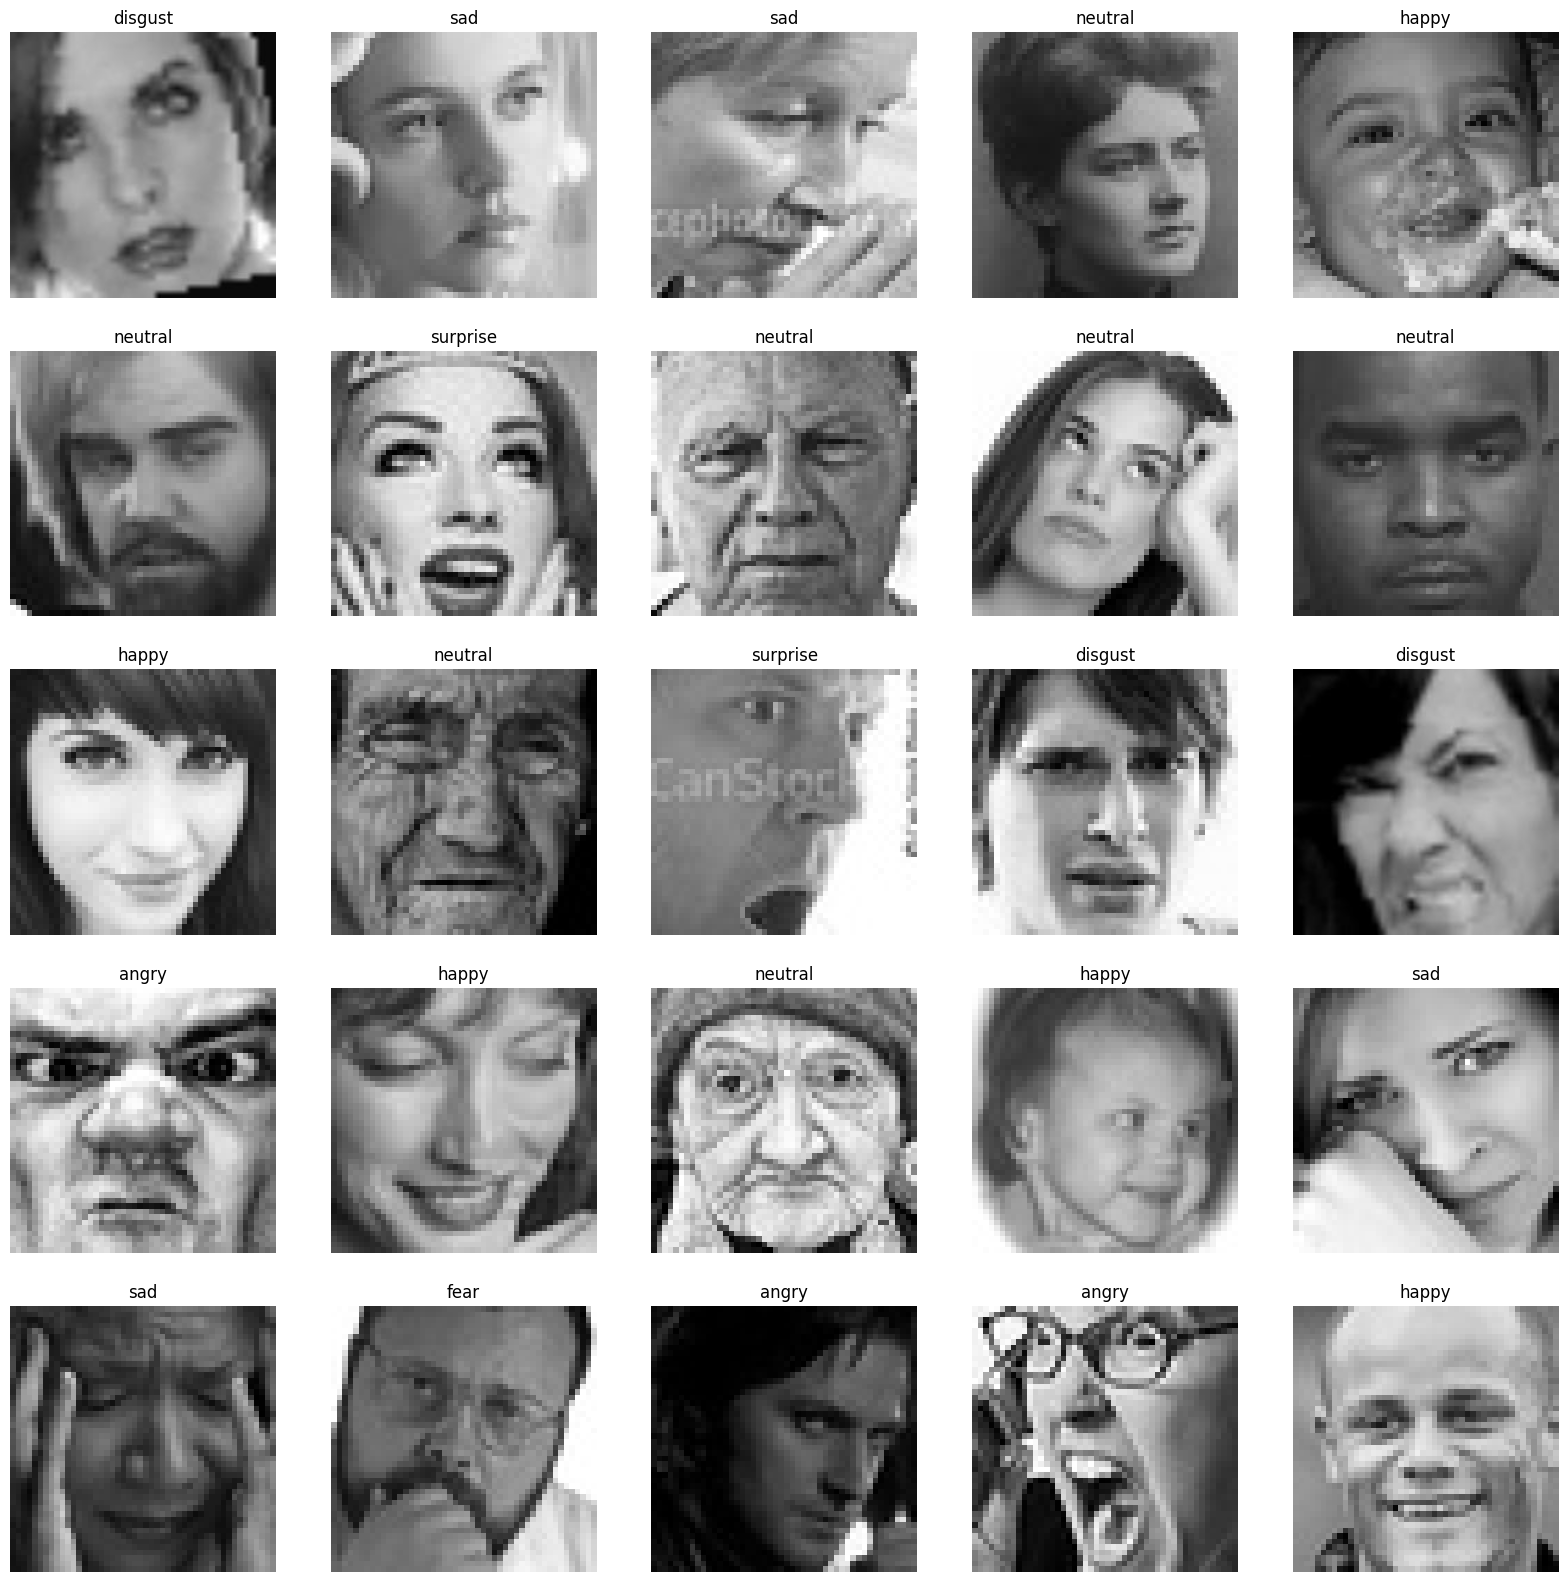

In [12]:


from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray')

# to display grid of images
plt.figure(figsize=(20, 20))
files = train.iloc[0:25]

# Corrected loop: use itertuples() and unpack correctly
for index, file, label in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)  # Assuming 'file' contains the file path
    img = np.array(img)  # Fixed typo: 'arrat' -> 'array'
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')


def extract_features(images, target_size=(48, 48)):
    features = []

    for img_path in tqdm(images):
        img = Image.open(img_path).convert('L')  # convert to grayscale if needed
        img = img.resize(target_size)            # ensure fixed size
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), target_size[0], target_size[1], 1)
    return features

In [13]:
train_features = extract_features(train['image'])

  0%|          | 0/30889 [00:00<?, ?it/s]

In [14]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [15]:
# normalize the image
x_train=train_features/255.0
x_test=test_features/255.0

In [16]:
## convery label to integer
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(train['label'])
y_train=le.transform(train['label'])
y_test=le.transform(test['label'])

In [17]:
y_train=to_categorical(y_train, num_classes=7)
y_test=to_categorical(y_test, num_classes=7)

In [23]:
#config
input_shape=(48,48,1)
output_class=7

## MOBILENETV2 with custom layers

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np

def create_transfer_model(input_shape=(48, 48, 1), output_class=7):
    # Create base model with pretrained weights
    base_model = MobileNetV2(weights='imagenet',
                            include_top=False,
                            input_shape=(48, 48, 3))  # MobileNet expects 3 channels

    inputs = Input(shape=(48, 48, 3))  # Already RGB input
    x = inputs

    # Pass through base model
    x = base_model(x, training=False)  # Freeze base model

    # Add custom layers
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Additional dense layers
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(output_class, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Freeze base model layers
    base_model.trainable = False

    # Compile with lower learning rate
    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Create the transfer learning model
transfer_model = create_transfer_model(input_shape=(48,48,1), output_class=7)
transfer_model.summary()

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max'),
    ModelCheckpoint('best_transfer_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

# Assuming x_train and x_test are your image data and y_train, y_test are your labels
# Convert grayscale to 3-channel for training data
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)

# Train the model
history = transfer_model.fit(
    x_train_rgb, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test_rgb, y_test),
    callbacks=callbacks
)

# Optional: Fine-tune some layers after initial training
def unfreeze_and_finetune(model):
    # Use correct name
    base_model = model.get_layer('mobilenetv2_1.00_224')
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False  # Freeze first 100 layers

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Only fine-tune if initial training shows good results
transfer_model = unfreeze_and_finetune(transfer_model)

history_fine = transfer_model.fit(
    x_train_rgb, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(x_test_rgb, y_test),
    callbacks=callbacks
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626,375 (10.02 MB)

 Trainable params: 365,063 (1.39 MB)

 Non-trainable params: 2,261,312 (8.63 MB)

Epoch 1/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.1777 - loss: 2.6828 - val_accuracy: 0.2934 - val_loss: 1.8797 - learning_rate: 1.0000e-04
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2456 - loss: 2.2215 - val_accuracy: 0.3165 - val_loss: 1.8114 - learning_rate: 1.0000e-04
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2665 - loss: 2.0723 - val_accuracy: 0.3169 - val_loss: 1.7772 - learning_rate: 1.0000e-04
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2839 - loss: 1.9673 - val_accuracy: 0.3246 - val_loss: 1.7422 - learning_rate: 1.0000e-04
Epoch 5/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.2942 - loss: 1.9001 - val_accuracy: 0.3249 - val_loss: 1.7213 - learning_rate: 1.0000e-04
Epoch 6/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3087 - loss: 1.8490 - val_accuracy: 0.3296 - val_loss: 1.7061 - learning_rate: 1.0000e-04
Epoch 7/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms

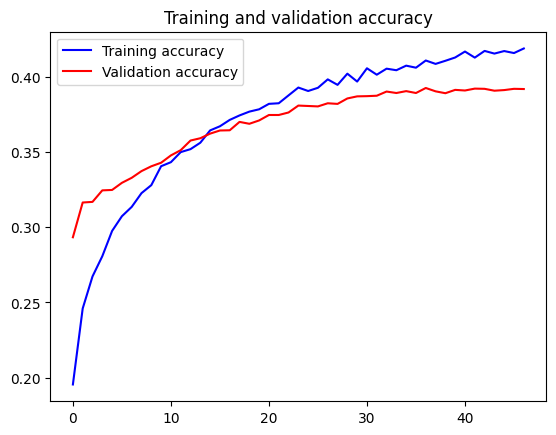

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

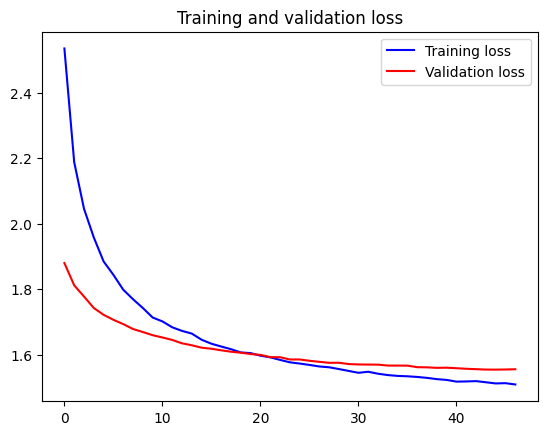

In [33]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Original Output: surprise
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Output: surprise


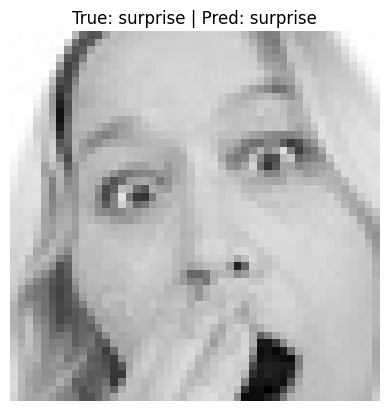

In [37]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick a random image from the test set
image_index = random.randint(0, len(x_test_rgb) - 1)

# Get original label
original_label = le.inverse_transform([np.argmax(y_test[image_index])])[0]
print("Original Output:", original_label)

# Preprocess the image (already converted to RGB and normalized)
img_input = x_test_rgb[image_index].reshape(1, 48, 48, 3)

# Predict
pred = transfer_model.predict(img_input)
predicted_class = le.inverse_transform([np.argmax(pred)])
print("Predicted Output:", predicted_class[0])

# Display the image (from grayscale original for visualization)
img = load_img(test['image'][image_index], color_mode='grayscale')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"True: {original_label} | Pred: {predicted_class[0]}")
plt.show()

In [41]:
transfer_model.save('mobilenetv2_emotion_model.h5')

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


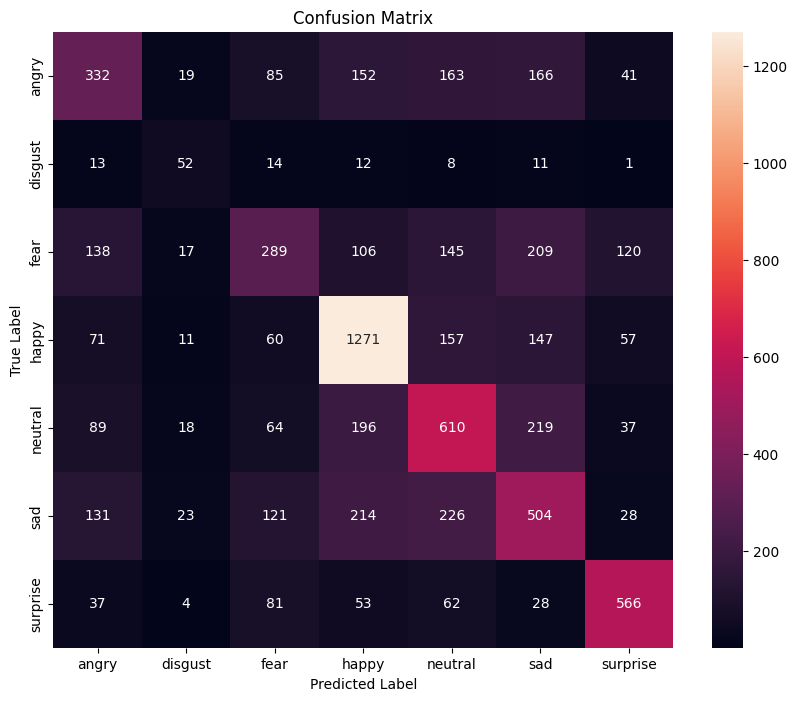

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# 1. Load your saved model
model = load_model('/content/mobilenetv2_emotion_model.h5')  # Adjust path if needed

# 2. Convert grayscale test images to RGB (3 channels)
x_test_rgb = np.repeat(x_test, 3, axis=-1)  # Shape becomes (N, 48, 48, 3)

# 3. Make predictions
y_pred = model.predict(x_test_rgb)

# 4. Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 5. Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 6. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

       angry       0.41      0.35      0.38       958
     disgust       0.36      0.47      0.41       111
        fear       0.40      0.28      0.33      1024
       happy       0.63      0.72      0.67      1774
     neutral       0.44      0.49      0.47      1233
         sad       0.39      0.40      0.40      1247
    surprise       0.67      0.68      0.67       831

    accuracy                           0.50      7178
   macro avg       0.47      0.48      0.48      7178
weighted avg       0.50      0.50      0.50      7178



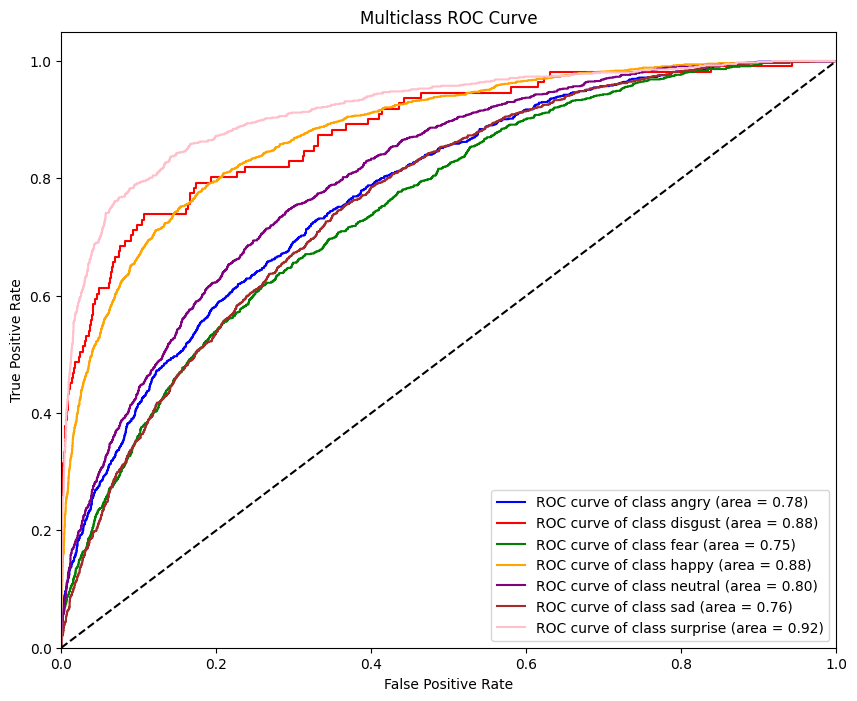

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

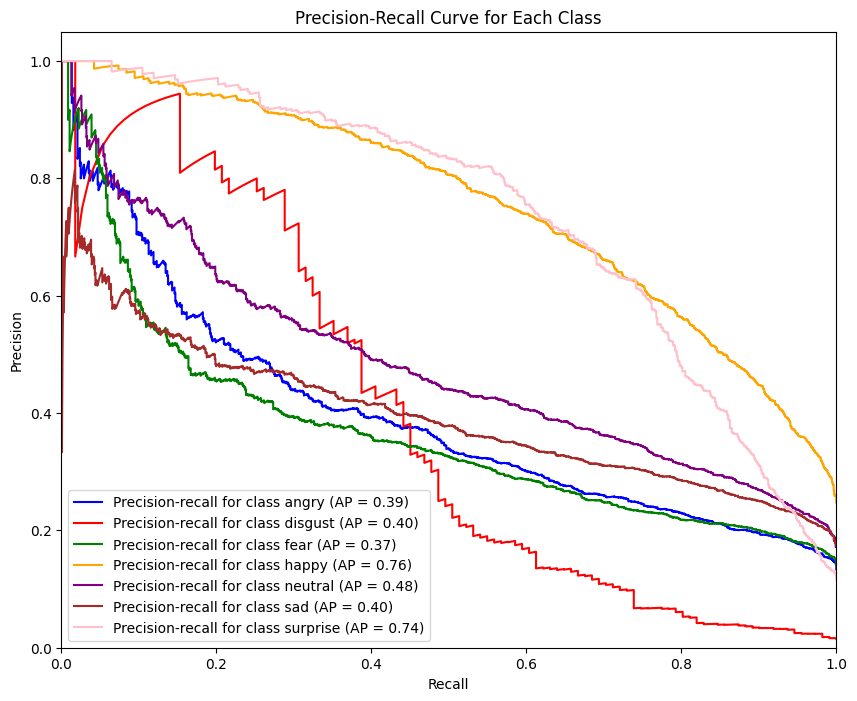


Additional Metrics:
Accuracy: 0.5049
Macro F1 Score: 0.4755
Weighted F1 Score: 0.4978
Cohen's Kappa: 0.3990


In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label='Precision-recall for class {0} (AP = {1:0.2f})'
             ''.format(le.classes_[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

# Calculate and display additional metrics
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}")

In [47]:
import pandas as pd
from datetime import datetime

# Create a timestamp for the report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save classification report to CSV
report = classification_report(y_true, y_pred_classes, target_names=le.classes_, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f'classification_report_{timestamp}.csv')

# Save metrics to text file
with open(f'model_metrics_{timestamp}.txt', 'w') as f:
    f.write("Model Evaluation Metrics\n")
    f.write("=======================\n\n")
    f.write(f"Evaluation Time: {timestamp}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true, y_pred_classes, target_names=le.classes_))
    f.write("\n\nAdditional Metrics:\n")
    f.write(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}\n")
    f.write(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}\n")
    f.write(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}\n")
    f.write(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}\n")

print(f"All reports saved with timestamp: {timestamp}")

All reports saved with timestamp: 20250503_175340


## MOBILENETV2 plain

In [18]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np

def create_plain_mobilenetv2(input_shape=(48, 48, 1), num_classes=7):
    # Create base model - must use 3-channel input for pretrained weights
    base_model = MobileNetV2(weights='imagenet',
                           include_top=False,
                           input_shape=(48, 48, 3))  # Note: 3 channels required

    inputs = Input(shape=(48, 48, 3))  # Already RGB input
    x = inputs

    # Pass through base model
    x = base_model(x)

    # Add standard MobileNetV2 top layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Freeze base model layers
    base_model.trainable = False

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Create model
model = create_plain_mobilenetv2(input_shape=(48,48,1), num_classes=7)
model.summary()

# Prepare callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('plain_mobilenet.keras', save_best_only=True)
]

# Convert grayscale to 3-channel by repeating values
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)

# Train model
history = model.fit(
    x_train_rgb, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_test_rgb, y_test),
    callbacks=callbacks
)

# Optional fine-tuning
def unfreeze_model(model):
    # Unfreeze base model
    model.layers[3].trainable = True  # Base model is 4th layer

    # Recompile with lower learning rate
    model.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Only fine-tune if initial training went well
model = unfreeze_model(model)
history_fine = model.fit(
    x_train_rgb, y_train,
    batch_size=32,
    epochs=40,
    validation_data=(x_test_rgb, y_test),
    callbacks=callbacks
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.2161 - loss: 2.0760 - val_accuracy: 0.2817 - val_loss: 1.8480 - learning_rate: 1.0000e-04
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3186 - loss: 1.7774 - val_accuracy: 0.3182 - val_loss: 1.7724 - learning_rate: 1.0000e-04
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3469 - loss: 1.7047 - val_accuracy: 0.3324 - val_loss: 1.7280 - learning_rate: 1.0000e-04
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3734 - loss: 1.6457 - val_accuracy: 0.3440 - val_loss: 1.7025 - learning_rate: 1.0000e-04
Epoch 5/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3837 - loss: 1.6183 - val_accuracy: 0.3465 - val_loss: 1.6839 - learning_rate: 1.0000e-04
Epoch 6/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3894 - loss: 1.5883 - val_accuracy: 0.3555 - val_loss: 1.6700 - learning_rate: 1.0000e-04
Epoch 7/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step

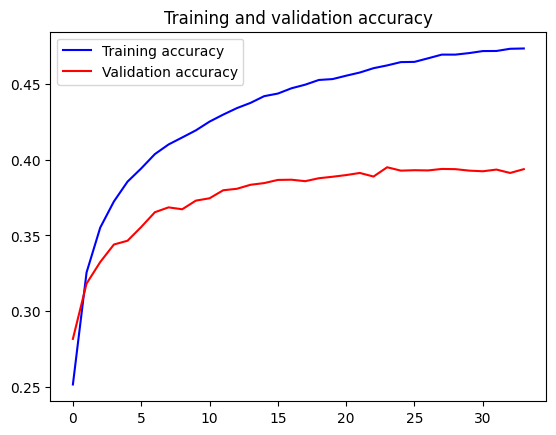

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

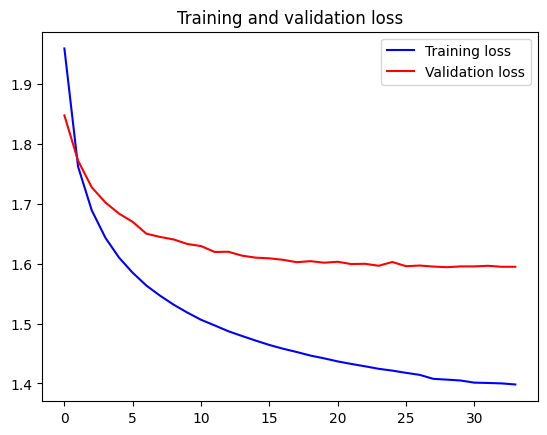

In [20]:
loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Output: angry


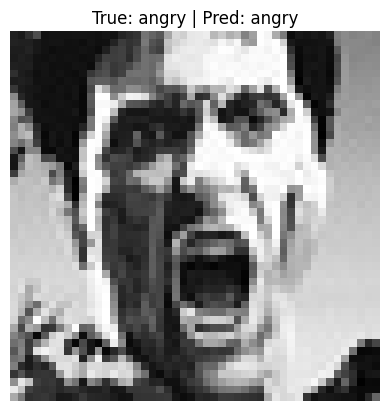

In [22]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pick a random image from the test set
image_index = random.randint(0, len(x_test_rgb) - 1)

# Get original label
original_label = le.inverse_transform([np.argmax(y_test[image_index])])[0]
print("Original Output:", original_label)

# Preprocess the image (already converted to RGB and normalized)
img_input = x_test_rgb[image_index].reshape(1, 48, 48, 3)

# Predict
pred = model.predict(img_input)
predicted_class = le.inverse_transform([np.argmax(pred)])
print("Predicted Output:", predicted_class[0])

# Display the image (from grayscale original for visualization)
img = load_img(test['image'][image_index], color_mode='grayscale')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"True: {original_label} | Pred: {predicted_class[0]}")
plt.show()

In [24]:
model.save('mobilenetv2_plain_emotion_model.h5')

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


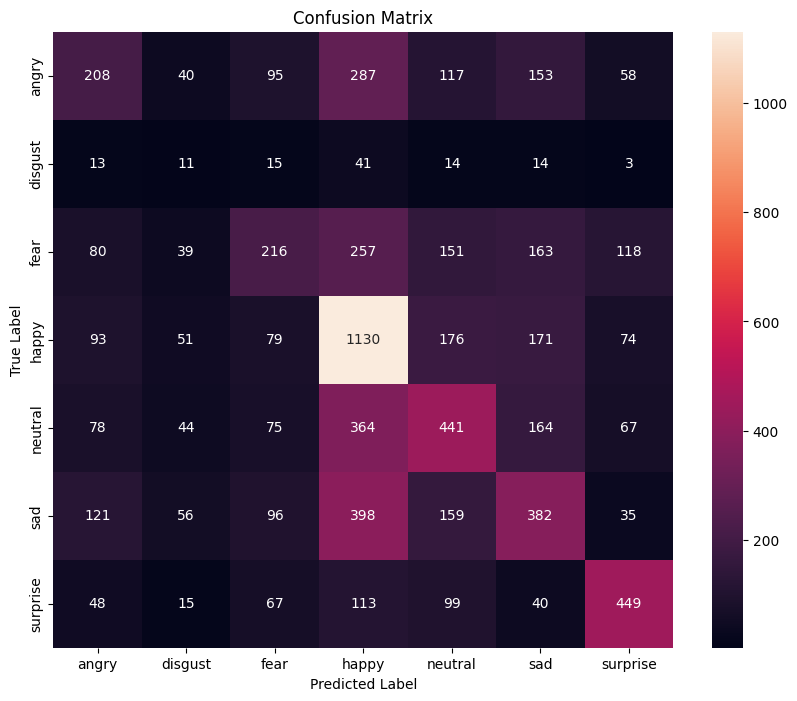

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# 1. Load your saved model
model = load_model('/content/mobilenetv2_plain_emotion_model.h5')  # Replace with your model path

# 2. Convert grayscale x_test to RGB if needed
if x_test.shape[-1] == 1:
    x_test_rgb = np.repeat(x_test, 3, axis=-1)
else:
    x_test_rgb = x_test

# 3. Make predictions
y_pred = model.predict(x_test_rgb)

# 4. Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 5. Generate confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 6. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

Classification Report:
              precision    recall  f1-score   support

       angry       0.32      0.22      0.26       958
     disgust       0.04      0.10      0.06       111
        fear       0.34      0.21      0.26      1024
       happy       0.44      0.64      0.52      1774
     neutral       0.38      0.36      0.37      1233
         sad       0.35      0.31      0.33      1247
    surprise       0.56      0.54      0.55       831

    accuracy                           0.40      7178
   macro avg       0.35      0.34      0.33      7178
weighted avg       0.39      0.40      0.38      7178



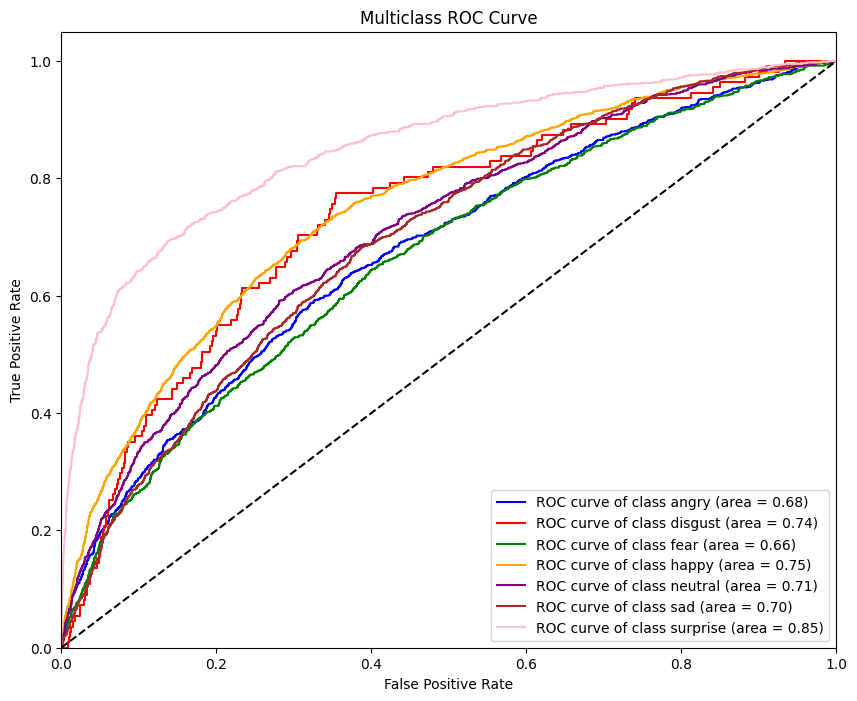

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_true, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

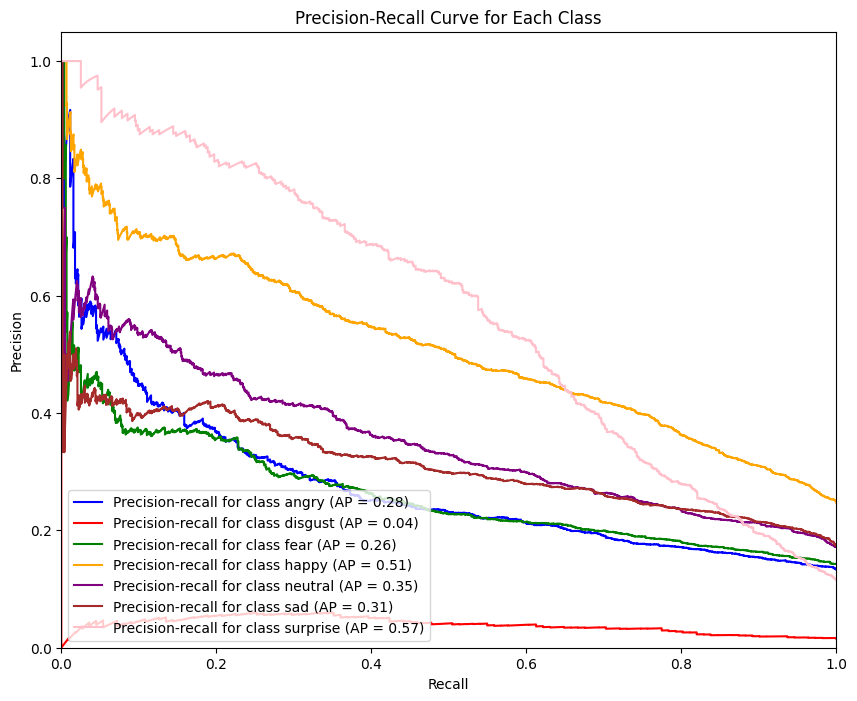


Additional Metrics:
Accuracy: 0.3952
Macro F1 Score: 0.3347
Weighted F1 Score: 0.3845
Cohen's Kappa: 0.2612


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color,
             label='Precision-recall for class {0} (AP = {1:0.2f})'
             ''.format(le.classes_[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()

# Calculate and display additional metrics
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}")

In [30]:
import pandas as pd
from datetime import datetime

# Create a timestamp for the report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save classification report to CSV
report = classification_report(y_true, y_pred_classes, target_names=le.classes_, output_dict=True)
pd.DataFrame(report).transpose().to_csv(f'classification_report_{timestamp}.csv')

# Save metrics to text file
with open(f'model_metrics_{timestamp}.txt', 'w') as f:
    f.write("Model Evaluation Metrics\n")
    f.write("=======================\n\n")
    f.write(f"Evaluation Time: {timestamp}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_true, y_pred_classes, target_names=le.classes_))
    f.write("\n\nAdditional Metrics:\n")
    f.write(f"Accuracy: {accuracy_score(y_true, y_pred_classes):.4f}\n")
    f.write(f"Macro F1 Score: {f1_score(y_true, y_pred_classes, average='macro'):.4f}\n")
    f.write(f"Weighted F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.4f}\n")
    f.write(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred_classes):.4f}\n")

print(f"All reports saved with timestamp: {timestamp}")

All reports saved with timestamp: 20250503_181907
